🎙 Grabando audio del micrófono...
✔ Grabación lista.
🔍 Buscando preámbulo de INICIO...
✔ Inicio detectado en 0.765 s
🔍 Buscando preámbulo de FIN...
✔ Fin detectado en 0.896 s
📦 Duración del mensaje extraído: 0.000 s


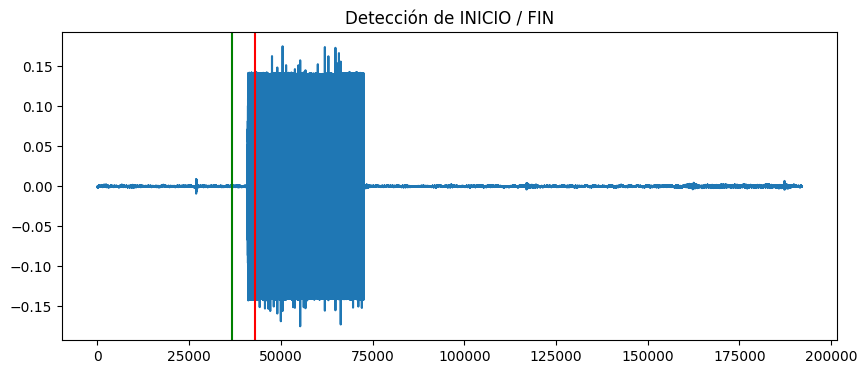

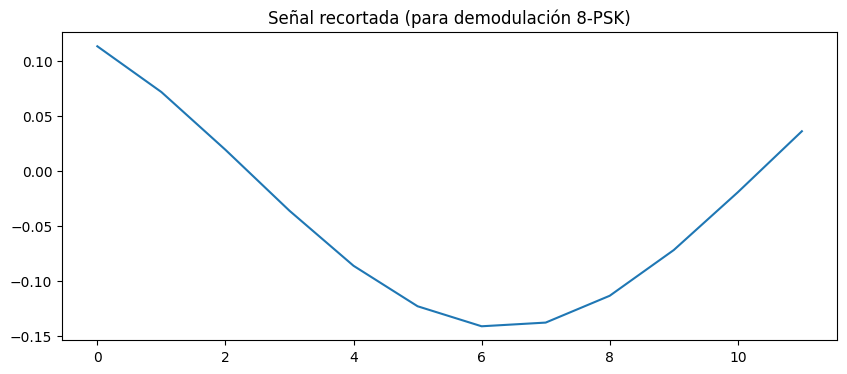

In [7]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy import signal

# ==========================================================
#   1) CORRELACIÓN NORMALIZADA
# ==========================================================

def norm_corr(x, h):
    corr = signal.correlate(x, h, mode='valid')
    energia_x = np.sqrt(signal.convolve(x**2, np.ones(len(h)), mode='valid'))
    energia_h = np.sqrt(np.sum(h**2))
    return corr / (energia_x * energia_h + 1e-12)


# ==========================================================
#   2) DETECCIÓN DEL PRIMER PICO
# ==========================================================

def detect_first_peak(ncc, thr=0.4):
    idx = np.where(ncc > thr)[0]
    return idx[0] if len(idx)>0 else None


# ==========================================================
#   3) RECEPTOR COMPLETO
# ==========================================================

def receive_frame(Tb=0.01, fs=48000, fc=3000, max_duration=7):

    print("🎙 Grabando audio del micrófono...")
    N = int(max_duration * fs)
    recording = sd.rec(N, samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    rx = recording[:,0]
    print("✔ Grabación lista.")

    # ==================================================
    #      1. MODULAMOS EL MISMO Preambulo QPSK
    # ==================================================
    pre_phases = generate_qpsk_preamble()
    _, s_pre = modulate_qpsk(pre_phases, Tb, fs, fc)
    h = s_pre / np.max(np.abs(s_pre))

    # Normalizamos recepción
    rx_norm = rx / (np.max(np.abs(rx)) + 1e-12)

    # ==================================================
    #      2. DETECTAR INICIO
    # ==================================================
    print("🔍 Buscando preámbulo de INICIO...")
    ncc_start = norm_corr(rx_norm, h)
    start_idx = detect_first_peak(ncc_start, thr=0.40)

    if start_idx is None:
        raise RuntimeError("❌ No se detectó el preámbulo de inicio.")

    print(f"✔ Inicio detectado en {start_idx/fs:.3f} s")

    # ==================================================
    #      3. DETECTAR FIN
    # ==================================================
    print("🔍 Buscando preámbulo de FIN...")

    search_region = rx_norm[start_idx + len(h):]
    ncc_end = norm_corr(search_region, h)
    end_rel = detect_first_peak(ncc_end, thr=0.40)

    if end_rel is None:
        raise RuntimeError("❌ No se detectó postámbulo.")

    end_idx = start_idx + len(h) + end_rel

    print(f"✔ Fin detectado en {end_idx/fs:.3f} s")

    # ==================================================
    #      4. EXTRAER SOLO LOS DATOS (8PSK)
    # ==================================================
    msg_signal = rx[start_idx + len(h) : end_idx]

    print(f"📦 Duración del mensaje extraído: {len(msg_signal)/fs:.3f} s")

    # ==================================================
    #      5. GRÁFICAS OPCIONALES
    # ==================================================
    plt.figure(figsize=(10,4))
    plt.plot(rx)
    plt.axvline(start_idx, color='g')
    plt.axvline(end_idx, color='r')
    plt.title("Detección de INICIO / FIN")
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(msg_signal)
    plt.title("Señal recortada (para demodulación 8-PSK)")
    plt.show()

    return msg_signal, fs
msg_signal, fs_rx = receive_frame(
    Tb=0.01,
    fs=48000,
    fc=3000,
    max_duration=4
)
